In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Dataset

In [ ]:
!mkdir training_data_64
!mkdir training_data_64/cheetah
!mkdir training_data_64/jaguar
!mkdir training_data_64/tiger

In [ ]:
!mkdir augmented_14400
!mkdir augmented_14400/cheetah
!mkdir augmented_14400/jaguar
!mkdir augmented_14400/tiger

In [ ]:
!unrar e "/content/drive/MyDrive/Dataset/training_data_64/cheetah.rar" "/content/training_data_64/cheetah"
!unrar e "/content/drive/MyDrive/Dataset/training_data_64/jaguar.rar" "/content/training_data_64/jaguar"
!unrar e "/content/drive/MyDrive/Dataset/training_data_64/tiger.rar" "/content/training_data_64/tiger"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Dataset/training_data_64/cheetah.rar

Extracting  /content/training_data_64/cheetah/aug_0_6121912.jpg            0%  OK 
Extracting  /content/training_data_64/cheetah/aug_100_7164689.jpg          1%  OK 
Extracting  /content/training_data_64/cheetah/aug_101_2901784.jpg          1%  OK 
Extracting  /content/training_data_64/cheetah/aug_102_9506627.jpg          2%  OK 
Extracting  /content/training_data_64/cheetah/aug_103_3202380.jpg          2%  OK 
Extracting  /content/training_data_64/cheetah/aug_104_9121367.jpg          3%  OK 
Extracting  /content/training_data_64/cheetah/aug_105_6957174.jpg          3%  OK 
Extracting  /content/training_data_64/cheetah/aug_106_9084765.jpg          4%  OK 
Extracting  /content/training_data_64/cheetah/aug_107_6815822.jpg          4%  OK 
Extracting  /content/train

In [ ]:
!unrar e "/content/drive/MyDrive/Dataset/augmented_14400/cheetah.rar" "/content/augmented_14400/cheetah"
!unrar e "/content/drive/MyDrive/Dataset/augmented_14400/jaguar.rar" "/content/augmented_14400/jaguar"
!unrar e "/content/drive/MyDrive/Dataset/augmented_14400/tiger.rar" "/content/augmented_14400/tiger"

Streaming output truncated to the last 5000 lines.
Extracting  /content/augmented_14400/jaguar/aug_392_1116542.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_1122204.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_202489.jpg            96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_2211650.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_2392956.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_269922.jpg            96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_2710708.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_358589.jpg            96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_4495676.jpg           96%  OK 
Extracting  /content/augmented_14400/jaguar/aug_392_4834767.jpg           96%  OK 
Extracting  /content/augmente

In [ ]:
import numpy as np
import cv2 as cv
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)

In [ ]:
def create_dataset(folders):
    dataset = []
    IMG_SIZE = 64
    CATEGORIES = ['cheetah', 'jaguar', 'tiger']
    
    for category in CATEGORIES:
        class_name = CATEGORIES.index(category)
        for file in os.listdir(os.path.join(folders, category)):
            path = os.path.join(folders, category, file)
            image = cv.imread(path, 0)    # grayscale
            
            # CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
            clahe_img = clahe.apply(image)
            
            # median filter + Otsu
            #blur = cv.GaussianBlur(clahe_img,(3,3),0)
            blur = cv.medianBlur(clahe_img, 3)
            otsu = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
            
            # Canny
            sigma = 0.3
            median = np.median(image)
            lower = int(max(0, (1.0 - sigma) * median))
            upper = int(min(255, (1.0 + sigma) * median))
            auto_canny = cv.Canny(otsu, lower, upper)
            
            image= cv.resize(auto_canny, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
            dataset.append([image, class_name])
            
    return dataset

dataset_ori = create_dataset(r'/content/training_data_64')
print('The number of original images : {}'.format(len(dataset_ori)))

dataset_aug = create_dataset(r'/content/augmented_14400')
print('The number of augmentation images : {}\n'.format(len(dataset_aug)))

# combine dataset with dataset augmentation
image_data = []
label_data = []
for image, label in dataset_ori:
    image_data.append(image)
    label_data.append(label)

for image, label in dataset_aug:
    image_data.append(image)
    label_data.append(label)
    
image_data = np.array(image_data)
#image_array = np.expand_dims(image_array, -1)    # (300, 180, 180) -> (300, 180, 180, 1)
label_data = np.array(label_data)

print('\nType : {}'.format(type(image_data)))
print('The number of the entire image : {}'.format(len(image_data)))
print('The number of the class image : {}'.format(len(label_data)))

The number of original images : 600
The number of augmentation images : 14400


Type : <class 'numpy.ndarray'>
The number of the entire image : 15000
The number of the class image : 15000


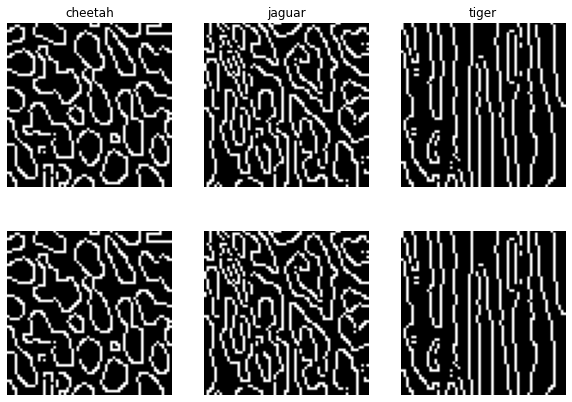

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(10,7))

ax[0,0].imshow(image_data[0], cmap='gray'), ax[0,0].set_title('cheetah'), ax[0,0].axis('off')
ax[0,1].imshow(image_data[200], cmap='gray'), ax[0,1].set_title('jaguar'), ax[0,1].axis('off')
ax[0,2].imshow(image_data[400], cmap='gray'), ax[0,2].set_title('tiger'), ax[0,2].axis('off')

ax[1,0].imshow(image_data[0], cmap='gray'), ax[1,0].axis('off')
ax[1,1].imshow(image_data[200], cmap='gray'), ax[1,1].axis('off')
ax[1,2].imshow(image_data[400], cmap='gray'), ax[1,2].axis('off')

plt.show()

### Feature Descriptor

In [ ]:
# HOG
def hog_descriptor(images): 
    hog_fd = []
    hog_img = []
    for sample in images:
        fd, img = hog(sample, orientations=9,
                      pixels_per_cell=(8, 8), cells_per_block=(2,2), 
                      visualize=True, multichannel=False, feature_vector=True)

        hog_fd.append(fd)
        hog_img.append(img)

    hog_array = np.array(hog_fd, np.float32)
    vis_array = np.array(hog_img)
    return hog_array, vis_array


In [ ]:
##### feature descriptor using phog level 1
def phog_descriptor(images):
    hog_fd = []
    for sample in images:
        ### Level 0
        hog_vector0,_ = hog_descriptor([sample])
        level_0 = np.array(hog_vector0).ravel()
        
        ### Level 1
        # Cut the image
        cut = images.shape[1] // 2
        left = sample[:, :cut]
        right = sample[:, cut:]

        img1 = left[:cut, :]
        img2 = right[:cut, :]
        img3 = left[cut:, :]
        img4 = right[cut:, :]
        
        # hog
        sub_img = [img1, img2, img3, img4]
        hog_vector1,_ = hog_descriptor(sub_img)    # (4,324)
        level_1 = np.array(hog_vector1).ravel()
        
        ### Concatenate grid_1 and grid_2
        a1 = len(level_0)    # (1764)
        a2 = len(level_1)    # (1296)
        level_0_1 = []
        for i in range(max(a1, a2)):
            if i < a1:
                level_0_1.append(level_0[i])
            if i < a2:
                level_0_1.append(level_1[i])
        
        hog_fd.append(level_0_1)
        
    hog_fd = np.array(hog_fd)
    print(hog_fd.shape)
    return hog_fd


start = time.perf_counter()
hog_fd = phog_descriptor(image_data)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(15000, 3060)
Elapsed 382.499 seconds.


### Classification

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


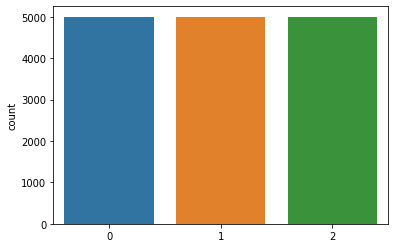

In [ ]:
# Check what is the dataset balance or not?
import seaborn as sns
sns.countplot(label_data)
#plt.xticks(rotation=90)
plt.show()

In [ ]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(hog_fd, label_data, 
                                                    shuffle=True,
                                                    random_state=0,
                                                    test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(12000, 3060)
(3000, 3060)


In [ ]:
start = time.perf_counter()
# Validation
pipe = SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma=0.1)
cv = StratifiedKFold(n_splits=10)
validation = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Training
pipe = SVC(C=10, kernel='rbf', decision_function_shape='ovo', gamma=0.1, probability=True)
pipe.fit(x_train, y_train)
y_pred_train = pipe.predict(x_train)
y_pred_test = pipe.predict(x_test)    # Testing

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

# ROC_AUC
pred_prob_test = pipe.predict_proba(x_test)
roc_auc_test = roc_auc_score(y_test, pred_prob_test, multi_class='ovo')

Elapsed 5507.019 seconds.


In [ ]:
# 01:33:56 s

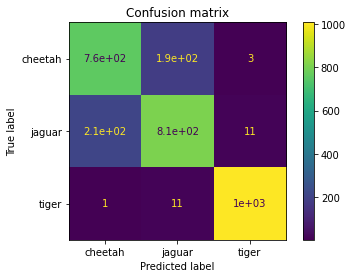

In [ ]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(pipe, x_test, y_test,
                             display_labels=['cheetah', 'jaguar', 'tiger'], )

disp.ax_.set_title("Confusion matrix")
plt.show()

In [ ]:
print('Accuracy_Val : {:.4f}\n'.format(validation.mean()))

print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
from sklearn.metrics import classification_report
target_names = ['cheetah', 'jaguar', 'tiger']
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test, 
                                                                  target_names=target_names))

print("\nAUC-ROC_test : {:.4f}".format(roc_auc_test))
print('Elapsed %.3f seconds.' % elapsed)

Accuracy_Val : 0.8459

Accuracy_test : 0.8593 Precision_test : 0.8577 Recall_test : 0.8582 F1-Score : 0.8579

classification report testing : 
               precision    recall  f1-score   support

     cheetah       0.78      0.80      0.79       948
      jaguar       0.80      0.79      0.79      1031
       tiger       0.99      0.99      0.99      1021

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000


AUC-ROC_test : 0.9592
Elapsed 5507.019 seconds.


In [ ]:
def calculate_sensitivity_specificity(y_test, y_pred):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred == 1) & (actual_pos)
    false_pos = (y_pred == 1) & (actual_neg)
    true_neg = (y_pred == 0) & (actual_neg)
    false_neg = (y_pred == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [ ]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test, y_pred_test)
print ('Sensitivity: {:.4f}'.format(sensitivity))
print ('Specificity: {:.4f}'.format(specificity))

Sensitivity: 0.7856
Specificity: 0.8006


### Predict

In [ ]:
def predict_image(path):
    image = cv.imread(path, cv.IMREAD_GRAYSCALE)    # grayscale
                
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(image)

    # median filter + Otsu
    #blur = cv.GaussianBlur(clahe_img,(3,3),0)
    blur = cv.medianBlur(clahe_img, 3)
    otsu = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

    # Canny
    sigma = 0.3
    median = np.median(image)
    lower = int(max(0, (1.0 - sigma) * median))
    upper = int(min(255, (1.0 + sigma) * median))
    auto_canny = cv.Canny(otsu, lower, upper)

    image_prep= np.expand_dims(auto_canny, 0)    # reshape

    # PHOG
    hog_fd = phog_descriptor(image_prep)

    # Model
    y_pred = pipe.predict(hog_fd)
    labels = ['cheetah', 'jaguar', 'tiger']

    if y_pred==0:
        label='Cheetah'
    elif y_pred==1:
        label='Jaguar'
    elif y_pred==2:
        label='Tiger'
    else:
        return 'Misclassification'

    # Plotting
    plt.imshow(image, cmap='gray')
    plt.title('pred: {}'.format(label))
    plt.axis('off')
    plt.show()

Saving aug_200_5564564.jpg to aug_200_5564564 (1).jpg
(1, 3060)


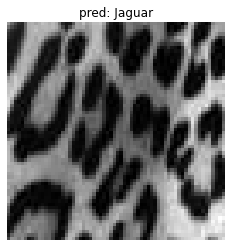

In [ ]:
from google.colab import files

uploaded = files.upload()
for path in uploaded.keys():
    predict_image(path)